In [6]:
import pandas as pd
from db.connection import get_connection, get_cursor
from db.queries import read_entries_query

def fetch_data_from_db():
    try:
        with get_connection() as conn:
            with get_cursor(conn) as cursor:
                # Execute the SQL query
                query = read_entries_query()  # Adjust this query to fetch the necessary data
                cursor.execute(query)
                
                # Fetch the data
                rows = cursor.fetchall()
                
                # Get column names from cursor description
                columns = [desc[0] for desc in cursor.description]
                
                # Convert to DataFrame
                df = pd.DataFrame(rows, columns=columns)
                
                # Rename 'ts' to 'timestamp' for consistency
                if 'ts' in df.columns:
                    df.rename(columns={'ts': 'timestamp'}, inplace=True)
                
                return df
    except Exception as e:
        print(f"Error fetching data from database: {e}")
        return None

# Fetch the data
df = fetch_data_from_db()

# Check if DataFrame is not None and has the correct columns
if df is not None:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Print the DataFrame to verify
    print(df.head())
else:
    print("Failed to fetch data or DataFrame is empty.")


            timestamp  temperature  humidity  id   rpm
0 2024-09-04 12:23:15        21.41     40.94   1  1430
1 2024-09-04 12:23:20        28.44     55.02   2  1995
2 2024-09-04 12:23:25        24.22     44.23   3  1716
3 2024-09-04 12:23:30        17.73     36.80   4  1621
4 2024-09-04 12:23:35        22.53     55.58   5  1324


In [7]:
print(df.dtypes)


timestamp      datetime64[ns]
temperature           float64
humidity              float64
id                      int64
rpm                     int64
dtype: object


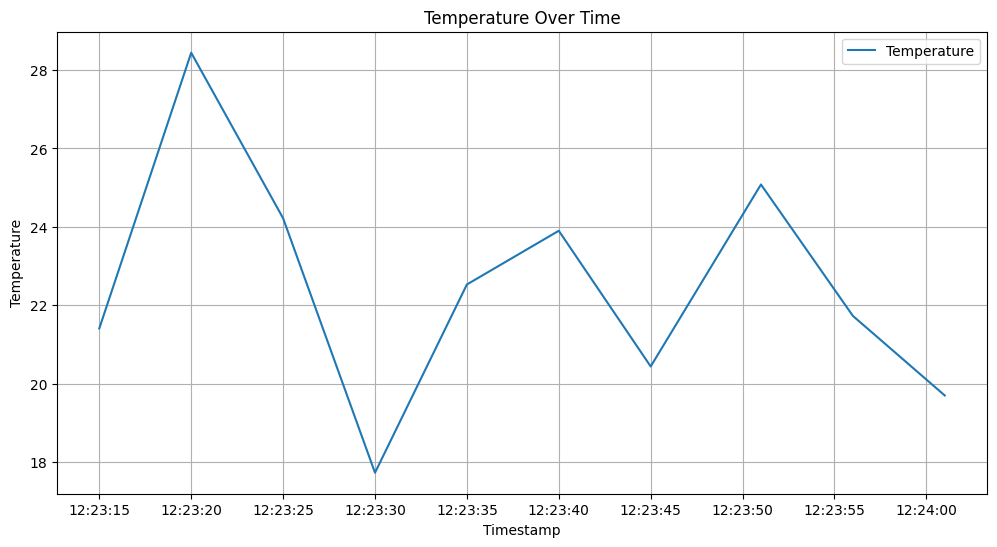

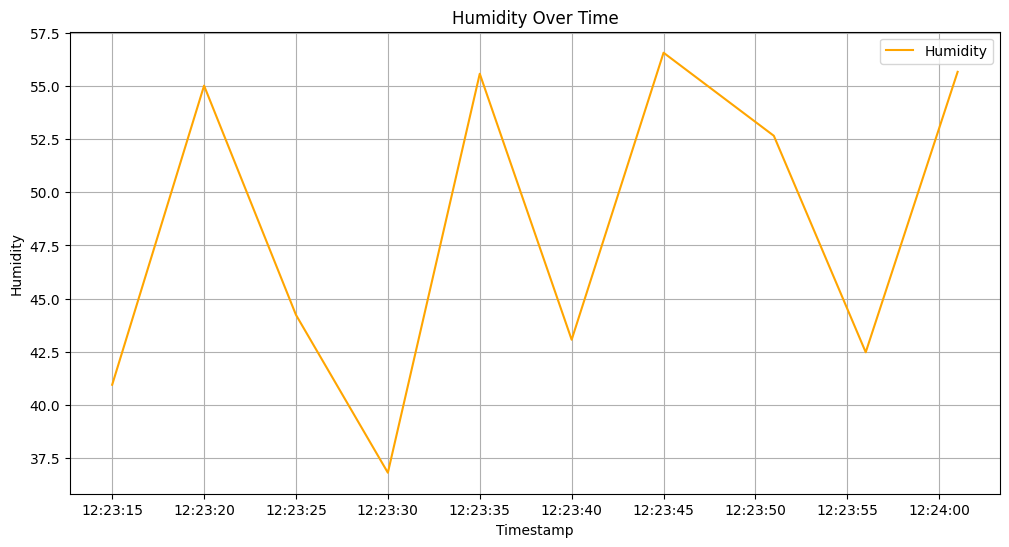

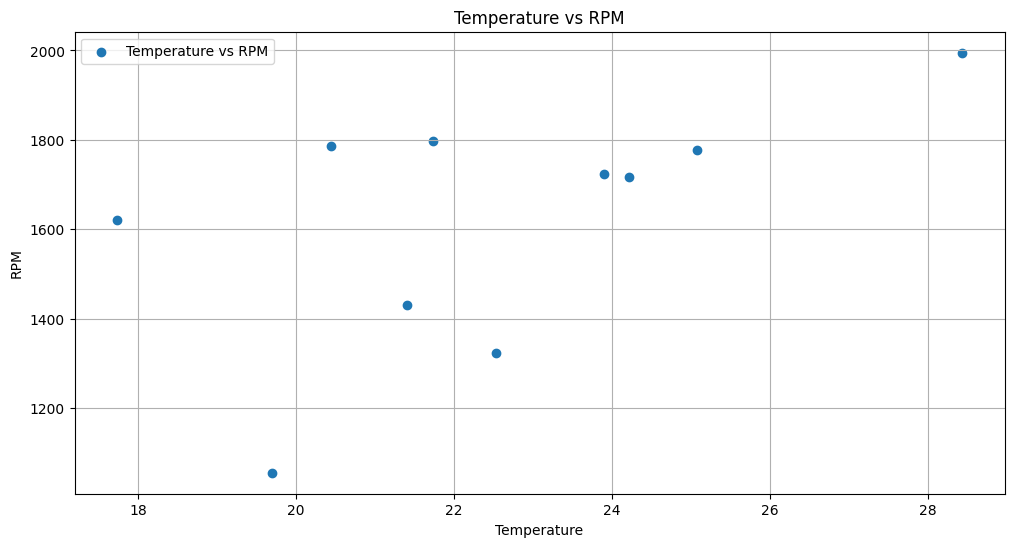

In [8]:
# Plot Temperature over Time
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['temperature'], label='Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Humidity over Time
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['humidity'], label='Humidity', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Humidity')
plt.title('Humidity Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for Temperature vs RPM
plt.figure(figsize=(12, 6))
plt.scatter(df['temperature'], df['rpm'], label='Temperature vs RPM')
plt.xlabel('Temperature')
plt.ylabel('RPM')
plt.title('Temperature vs RPM')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(df.describe())



                           timestamp  temperature   humidity        id  \
count                             10    10.000000  10.000000  10.00000   
mean      2024-09-04 12:23:37.800000    22.518000  48.300000   5.50000   
min              2024-09-04 12:23:15    17.730000  36.800000   1.00000   
25%    2024-09-04 12:23:26.249999872    20.682500  42.617500   3.25000   
50%       2024-09-04 12:23:37.500000    22.130000  48.445000   5.50000   
75%       2024-09-04 12:23:49.500000    24.140000  55.440000   7.75000   
max              2024-09-04 12:24:01    28.440000  56.570000  10.00000   
std                              NaN     3.045462   7.485595   3.02765   

               rpm  
count    10.000000  
mean   1622.600000  
min    1055.000000  
25%    1477.750000  
50%    1720.000000  
75%    1784.500000  
max    1995.000000  
std     276.364976  


In [10]:
correlations = df[['temperature', 'humidity', 'rpm']].corr()
print(correlations)


             temperature  humidity       rpm
temperature     1.000000  0.325294  0.559471
humidity        0.325294  1.000000 -0.124283
rpm             0.559471 -0.124283  1.000000


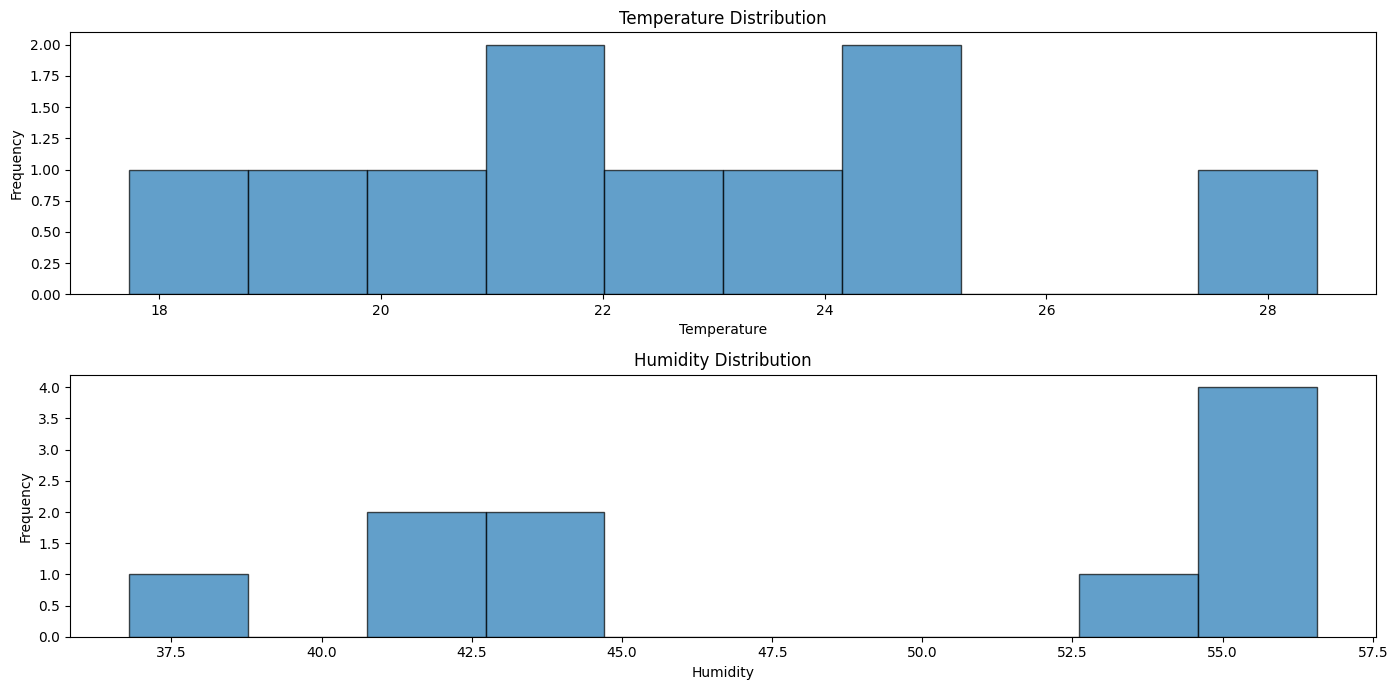

In [11]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.hist(df['temperature'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')

plt.subplot(2, 1, 2)
plt.hist(df['humidity'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Humidity Distribution')

plt.tight_layout()
plt.show()



In [12]:
df_hourly = df.resample('H', on='timestamp').mean()
print(df_hourly)


                     temperature  humidity   id     rpm
timestamp                                              
2024-09-04 12:00:00       22.518      48.3  5.5  1622.6


/tmp/ipykernel_80819/3085794060.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').mean()


In [13]:
start_time = '2024-09-03 13:37:00'
end_time = '2024-09-03 13:38:00'
filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
print(filtered_df)


Empty DataFrame
Columns: [timestamp, temperature, humidity, id, rpm]
Index: []


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA
df.set_index('timestamp', inplace=True)

# Forecasting temperature
temperature_series = df['temperature']
temp_model = ARIMA(temperature_series, order=(1, 1, 1))
temp_model_fit = temp_model.fit()
temp_forecast = temp_model_fit.forecast(steps=5)
print("Temperature Forecast:")
print(temp_forecast)

# Forecasting humidity
humidity_series = df['humidity']
humidity_model = ARIMA(humidity_series, order=(1, 1, 1))
humidity_model_fit = humidity_model.fit()
humidity_forecast = humidity_model_fit.forecast(steps=5)
print("Humidity Forecast:")
print(humidity_forecast)


Temperature Forecast:
10    22.708901
11    22.530216
12    22.540827
13    22.540197
14    22.540235
Name: predicted_mean, dtype: float64
Humidity Forecast:
10    45.706989
11    50.325686
12    48.184530
13    49.177136
14    48.716979
Name: predicted_mean, dtype: float64


/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta